# Walkthrough 2: Making quantum matter 
This notebook does not run any jobs 

## Introduction ##

The most basic operation of Oqtant and Oqtant QMS is the creation of quantum matter in the form of a Bose-Einstein Condensate (BEC).  Using Oqtant, users have control of the final cooling step to quantum degeneracy -- the forced radiofrequency evaporation that cools atoms to the ultracold quantum regime.  We saw this in the previous walkthrough, where we controlled the final state by specifying a target atomic ensemble temperature.

Each run of the Oqtant hardware is separated into two distinct phases -- an *evaporation* phase where forced radiofrequency evaporation takes place that cools the atoms to quantum degeneracy, and a *manipulation* phase where that matter can be held and/or manipulated. In this walthrough, we will focus mostly on the evaporation phase, leaving exploration of manipulation of the quantum matter for later walkthroughs.


This, along with all our example notebooks are publicly available for download from our [GitLab repository.](https://gitlab.com/infleqtion/albert/oqtant-documentation/-/tree/main/oqtant_documentation/docs/examples?ref_type=heads)

### Imports and user authentication ###

In [1]:
from oqtant.schemas.quantum_matter import QuantumMatterFactory

qmf = QuantumMatterFactory()
qmf.get_login()

In [2]:
qmf.get_client()

Job Limits:
╒══════════════╤═══════════════════╤═══════════════╤═══════════════════════╕
│   Daily Used │   Daily Remaining │   Daily Limit │   Purchased Remaining │
╞══════════════╪═══════════════════╪═══════════════╪═══════════════════════╡
│            0 │                10 │            10 │                    10 │
╘══════════════╧═══════════════════╧═══════════════╧═══════════════════════╛


## Create a QuantumMatter object ##

### Control QuantumMatter lifetime and time of flight imaging ###

As seen in walkthrough 1, the simplest way to create a QuantumMatter object is to provide the target temperature as an input parameter, along with an (optional) name.  

We can also control how long the atom ensemble is held after evaporation is complete by passing a *lifetime* parameter, with the units of milliseconds. After the hold time (lifetime) is complete, a destructive image will be taken of the ensemble.  

*Note: that this usage of the term *lifetime* is not to be confused with the common usage in physics of an exponentially decaying quantity's $1/e$ time constant, which is also commonly called the lifetime.*

In this example, we will take a "time of flight" image (the default) where the ensemble is released from its trap and allowed to freely fall under gravity, expanding according to its effective trap temperature, before the image is taken.  How long the cloud falls before the image is captured is controlled by the *time_of_flight* input parameter, also with the units of milliseconds.  

Begin by constructing a QuantumMatter object that produces a resulting ensemble with a (target) temperature of 100 nK, a lifetime of 10 ms, and a time of flight of 8 ms.  Again, we use the QuantumMatterFactory: 

In [3]:
matter = qmf.create_quantum_matter(
    temperature=100,
    lifetime=10,
    time_of_flight=8,
    name="QM w/ lifetime + tof control",
)

Control of the time of flight is useful for revealing some of the unique features of a BEC.  

The quantum properties of the atoms in the condensate lead to a distinct expansion as a large, slowly expanding peak that suddenly forms below the transition temperature.  As this peak expands during the time of flight, features of quantum matter such as *shape inversion* can be observed.  Here, an asymmetric atom ensemble, with one or more axes spatially smaller than the other(s), inverts during freefall -- the narrow dimension(s) expand more quickly than the wide dimension, inverting the aspect ratio of the ensemble -- due to (repulsive) internal interaction energy amongst the atoms.  

The (classical) behavior of the thermal fraction, those atoms that are not condensed, can be studied.  Hotter thermal clouds expand faster and become more diffuse more quickly, while colder clouds expand more slowly.  The details of the cloud shape during the time of flight depend on the initial sample temperature, density, population, and condensed fraction, all of which can be controlled by the user using Oqtant via the web app or OqtAPI.

### Visualize forced radiofrequency evaporation dynamic behavior ###

The QuantumMatter object has helper methods for visualizing what behavior will be carried out on Oqtant hardware.  

In our example, the only dynamic quantities are the radiofrequency power and frequency (detuning, relative to the energetic bottom of the trap that holds the atom ensemble) applied to the atoms during evaporation.  When specifying a target temperature, these dynamics are automatically calculated in the backend. 

We will see below how the evaporation sequence can be customized further and how radiofrequency radiation can also be applied during the manipulation phase.

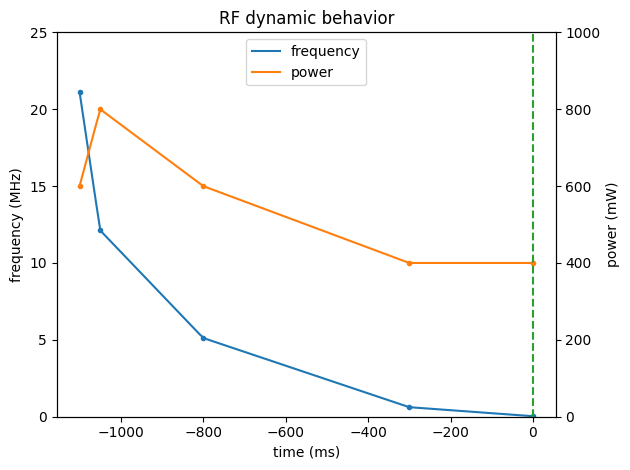

In [4]:
matter.show_rf_dynamics()

Looking closely at the plot above, we notice that all the times associated with the forced evaporation sequence are negative. Negative times correspond to the evaporation phase and positive times to the manipulation phase.  This offset is taken care of in the backend and will still occur even with fully user-defined evaporation curves (see below).  In the plot above, the vertical dashed line indicates the separation of the overall program into the evaporation (t $\leq$ 0) and manipulation (t $>$ 0) phases.

Note that the radiofrequency evaporation frequency is referenced to the energetic trap bottom.  Therefore, the frequency can be interpreted as a *detuning*, where a detuning of zero means we will remove all atoms from the trap.  The closer we get to zero detuning during evaporation, the colder our resulting ensemble will be.  This comes at the expense of atom population as more atoms need to be removed via evaporation in order to achieve a colder final temperature.  These tradeoffs, and the interplay between evaporation dynamic RF power and frequency and the produced ensemble characteristics, are easily explored using Oqtant.

### Full control of the forced evaporation sequence ###

Further control and exploration of the final temperature, population, and condensed/thermal fractions of the produced atom ensemble is made possible by passing a custom `RfEvap` object as an optional `rf_evap` parameter to the QuantumMatter object being instantiated.  

#### Specify custom RF evaporation using the RfEvap object ####

Create custom forced evaporation sequences by using the *QuantumMatterFactory* to create an *RfEvap* object, which takes *equal length* lists of times, powers, and frequencies, along with an interpolation option, discussed below.  This data represents ordered pairs of (times, frequencies) and (times, powers) that are evaluated, according to the interpolation choice, over the time of the evaporation sequence.  

In [5]:
evap = qmf.create_rf_evap(
    times=[0, 400, 800, 1200, 1600],
    powers=[600, 800, 600, 400, 200],
    frequencies=[20, 10, 5, 2.5, 1.25],
    interpolation="LINEAR",
)

Use this RfEvap object to create a *matter* object:

In [6]:
matter = qmf.create_quantum_matter(
    rf_evap=evap, name="making quantum matter with direct rf control"
)

We can now see the customized evaporation curves of our *matter* object:

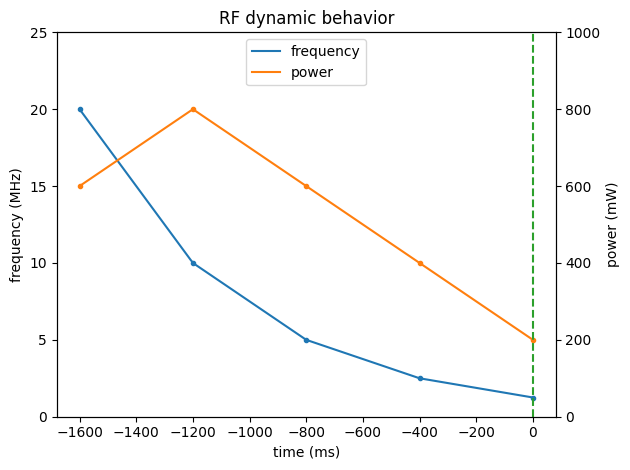

In [7]:
matter.show_rf_dynamics()

#### RfEvap interpolation options ####

Aside from the "LINEAR" interpolation option specified above for our *RfEvap* object, the "OFF" option to give stepwise behavior of the evaporation frequency and power in time.  The frequency or power value is held constant at the value of the previous datapoint.  Both frequency and power share the same interpolation behavior.  Let us see what this other interpolation option gives for the evaporation sequence:

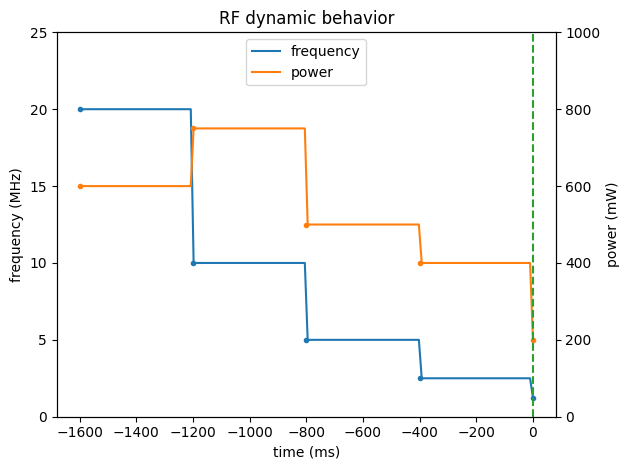

In [8]:
# try out a different (temporal) interpolation option
evaporation = qmf.create_rf_evap(
    times=[0, 400, 800, 1200, 1600],
    powers=[600, 750, 500, 400, 200],
    frequencies=[20, 10, 5, 2.5, 1.25],
    interpolation="OFF",
)

matter = qmf.create_quantum_matter(
    rf_evap=evaporation, name="direct rf control without interpolation"
)

matter.show_rf_dynamics()

*Note: With interpolation="OFF", the last point of frequency and power is not used as the instantaneous frequency and power are determined by the previous datapoint.*

#### Specify a custom RfEvap object and target temperature simulaneously ####

If a target temperature is specified at the same time as a customized `RfEvap` object, the final frequency of radiation applied to the atoms will be tweaked to attempt to achieve the desired temperature.  To use your unmodified custom evaporation sequence, avoid passing both parameters together.  

In [9]:
evaporation = qmf.create_rf_evap(
    times=[0, 400, 800, 1200, 1600],
    powers=[600, 750, 500, 400, 200],
    frequencies=[20, 10, 5, 2.5, 0.1],
    interpolation="LINEAR",
)

# specify only the custom rf_evap input parameter
matter = qmf.create_quantum_matter(rf_evap=evaporation)
print("the final frequency is", matter.rf_evaporation.frequencies_mhz[-1], "mHz")

# specify both the custom rf_evap input parameter as well as a target temperature
matter = qmf.create_quantum_matter(temperature=500, rf_evap=evaporation)
print("the final frequency is", matter.rf_evaporation.frequencies_mhz[-1], "mHz")

the final frequency is 0.1 mHz
the final frequency is 0.1675 mHz


### Apply a radio frequency "shield" during the manipulation phase ###

Oqtant can also use RF radiation to throw away any atoms that are heated above a certain temperature, *shielding* the rest of the ensemble from destructive collisions with hot atoms.  

Apply forced radiofrequency evaporation (at fixed power and frequency/detuning) during the manipulation phase by creating an `RfShield` (*RFShield*) object with the *factory*. Much like we were able to create a quantum matter program above by passing a *RfEvap* object as the `rf_evap` parameter; to add the *RfShield* to the *matter* object, we pass an additional `rf_shield` parameter.

This feature will be most useful when we start manipulating the quantum matter sample with, e.g., externally applied optical fields.  We will encounter this more advanced level of manipulation in the following walkthrough.

*NOTE: to apply a shield, you must specify a finite (>0) lifetime such that the manipulation phase has a finite time over which the shield can be applied.  The default lifetime value, which will be used if not explicit lifetime parameter is provided, is 10 ms.*


In [10]:
evaporation = qmf.create_rf_evap(
    times=[0, 400, 800, 1200, 1600],
    powers=[600, 750, 500, 400, 200],
    frequencies=[20, 10, 5, 2.5, 0.1],
    interpolation="LINEAR",
)

shield = qmf.create_rf_shield(power=100, frequency=10)

matter = qmf.create_quantum_matter(
    rf_evap=evaporation,
    rf_shield=shield,
    lifetime=60,
    name="matter with shield during manipulation phase",
)

The rf shield is included in the resulting rf dynamics:

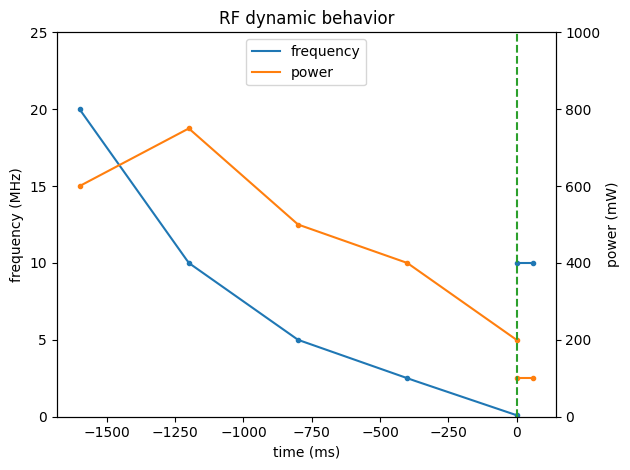

In [11]:
matter.show_rf_dynamics()

### Visualize the (magnetic) trapping potential ###

During the forced RF evaporation sequence, and subsequently during the manipulation stage, the ultracold quantum matter is trapped in three dimensions by magnetic fields produced by an atom chip that forms part of the ultra-high vacuum cell walls.  

The trapping potential is *asymmetric*, having cylindrical symmetry with two equal high-frequency (radial) trap axes and one relatively weak axial trap frequency.  The trapping frequencies of the strong- and weak-trapping axis are around 400 and 50 Hz, respectively.  This arrangement gives rise to "sausage"- or "cigar"-shaped atom ensembles.  

Only the long-axis of the cloud has a controllable position parameter for *QuantumMatter* objects and manipulation of the atom ensemble.  All positions correspond to the weak-trap axis.  

We can view the trapping potential energy as a function of this position:

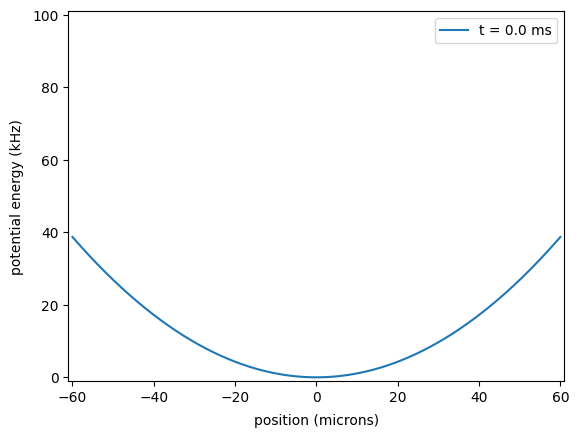

In [12]:
matter.show_potential()

The curvature of this trapping potential corresponds to an oscillation frequency of around 40 Hz for atoms in the trap.

## Advanced topics and discussion ##

### Understanding actual delivered RF power ###

The figures above showing the user-provided RF evaporation and shield dynamics are in some ways misleading.  

In the hardware implementation, the RF radiation applied to the ultracold atoms is transmitted through an RF loop optimized for a frequency of approximately 40 MHz.  This allows for maximum delivered RF power at high frequencies (detunings) where the evaporation process requires more power, but it also means that the delivered RF power decays as the frequency is lowered towards the energetic trap bottom (0 frequency in Oqtant).  This means that the actual delivered RF power is not what is provided in the user-defined *RfEvap* object passed to the *matter* object.  

To view the actual behavior of the delivered RF power, within multiplication by an arbitrary constant, you can pass the *corrected = True* option to the `show_rf_dynamics()` method:    

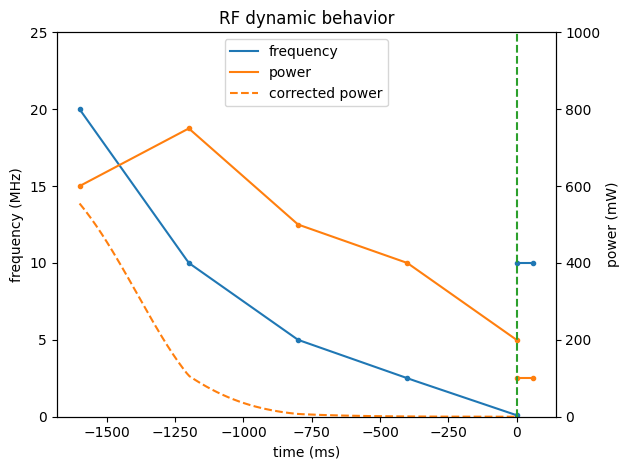

In [13]:
matter.show_rf_dynamics(corrected=True)

### Peeking under the hood ###

In the background of OqtAPI, each *matter* and constituent object, e.g. *RfShield* and *RfEvap* objects, gets converted to a data structure that can be consumed by Oqtant QMS.  This structure can be revealed using the *.model_dump()* method for each *matter* object.  

In [14]:
matter = qmf.create_quantum_matter(temperature=100, name="implementation details!")
matter.model_dump()

{'name': 'implementation details!',
 'temperature': 100.0,
 'lifetime': 10,
 'image': <ImageType.TIME_OF_FLIGHT: 'TIME_OF_FLIGHT'>,
 'time_of_flight': 12,
 'rf_evap': None,
 'rf_shield': None,
 'barriers': None,
 'landscape': None,
 'lasers': None,
 'note': None,
 'client': <oqtant.oqtant_client.OqtantClient at 0x7fd8c8b0ef10>,
 'result': None,
 'job_id': None,
 'output': None,
 'is_sim': False,
 'sim': None}

For advanced creation and manipulation, the data fields of a *matter* object can be accessed and/or edited programmatically using this structure, e.g. 

In [15]:
matter.name = "new name!"
matter.temperature = 250
matter.input.time_of_flight_ms = 20
matter.model_dump()

{'name': 'new name!',
 'temperature': 250.0,
 'lifetime': 10,
 'image': <ImageType.TIME_OF_FLIGHT: 'TIME_OF_FLIGHT'>,
 'time_of_flight': 12,
 'rf_evap': None,
 'rf_shield': None,
 'barriers': None,
 'landscape': None,
 'lasers': None,
 'note': None,
 'client': <oqtant.oqtant_client.OqtantClient at 0x7fd8c8b0ef10>,
 'result': None,
 'job_id': None,
 'output': None,
 'is_sim': False,
 'sim': None}

### Data limits and object data validation ###

All *matter* objects are validated to ensure that they contain valid parameters before being submitted to Oqtant hardware. If these rules are violated, we encounter an error indicating that the created object is not valid (a validation error).

Ex: the manipulation phase lifetime is limited, target temperatures are required to be non-negative, etc. 

In [16]:
# matter = qmf.create_quantum_matter(
#    temperature=100,
#    lifetime=1000,  # too long!
#    time_of_flight=8,
#    name="lifetime is too long!",
# )

ValidationError: 1 validation error for QuantumMatter
lifetime
  Input should be less than or equal to 80 [type=less_than_equal, input_value=1000, input_type=int]
    For further information visit https://errors.pydantic.dev/2.5/v/less_than_equal